# 1. Install and import the game and other dependencies

In [1]:
#Import the super mario game in the notebook
import gym_super_mario_bros

#Import the Joypad wrapper in the notebook
from nes_py.wrappers import JoypadSpace

#Import the simple controls so that the model just needs to control some movements of our agent (here Mario)
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# Changes the game from colour image (RGB) to grayscale so that our processing becomes faster as we need to deal with less data 
from gym import ObservationWrapper
from gym.spaces import Box

# VecFrameStack allows us to work with our stacked enviroments by letting us know the information of previous frames. DummyVecEnv transforms our model so that we can pass it to our AI model. 
from stable_baselines3.common.vec_env import VecFrameStack, SubprocVecEnv, VecMonitor, VecNormalize

# Import the Super Mario RAM utils
from Super_Mario_RAM_utils import MarioRAMGrid

# Import Numpy for mathematics
import numpy as np

# Import pyplot for plotting
from matplotlib import pyplot as plt

# Import time for measuring the training time
import time

In [3]:
# Importing the optimization frame - HPO
# import optuna
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
import gc
# Import os for file path management
import os

# Import PPO algorithm to train our model
from stable_baselines3 import PPO

# Import Base Callback for saving models and to continue from there
from stable_baselines3.common.callbacks import BaseCallback

# 2. Preprocessing the environment

In [4]:
class RAMAndSkipWrapper(ObservationWrapper):
    def __init__(self, env, n_stack=4, n_skip=2):
        super().__init__(env)
        self.n_stack = n_stack
        self.n_skip = n_skip
        self.width = 16
        self.height = 13
        self.observation_space = Box(
            low=-2, high=2, shape=(self.height, self.width, self.n_stack), dtype=np.int8
        )
        
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.int8)
        
    def observation(self, obs):
        grid = MarioRAMGrid(self.env)
        frame = grid.rendered_screen # The RAM map for the current frame
        
        self.frame_stack[:,:,1:] = self.frame_stack[:,:,:-1] # Shift frame_stack by 1 to the right
        self.frame_stack[:,:,0] = frame # Add the current frame to stack on the left
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs
    
    def reset(self):
        obs = self.env.reset()
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1), dtype=np.int8)
        grid = MarioRAMGrid(self.env)
        frame = grid.rendered_screen # 2d array

        for i in range(self.frame_stack.shape[-1]):
            self.frame_stack[:,:,i] = frame

        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

In [5]:
def make_env(seed, env_name, n_stack, n_skip):
    def init():
        env = gym_super_mario_bros.make(env_name)
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = RAMAndSkipWrapper(env, n_stack=n_stack, n_skip=n_skip)

        return env
    
    return init

In [6]:
#Location of trained and logged files 
CHECKPOINT_DIR = './train/WithSkipWrapper'
LOG_DIR = './logs'
HPO_LOG_DIR = './opt_logs'
HPO_CHECKPOINT_DIR = './opt_train'

In [7]:
env_name = "SuperMarioBros-1-2-v0"
n_stack = 4
n_skip = 4

env = make_env(0, env_name, n_stack, n_skip)()

In [8]:
env.observation_space.shape

(13, 16, 4)

In [9]:
state = env.reset()

In [10]:
# test env_wrap
done = True
for i in range(150):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())

In [38]:
state, reward, done, info = env.step(env.action_space.sample())

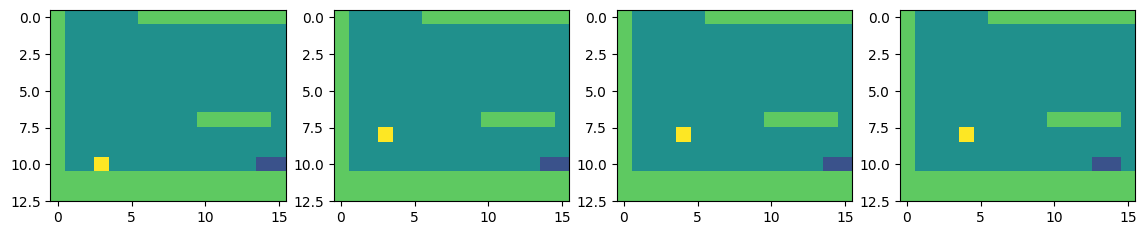

In [39]:
fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    ax[i].imshow(state[:,:,n_stack-i-1], vmin=-2, vmax=2)
plt.show()

In [40]:
env = SubprocVecEnv([make_env(i, env_name, n_stack, n_skip) for i in range(6)])
env = VecMonitor(env, LOG_DIR)

# 3. Setup RL Model

In [41]:
#Set the learning rate
def linear_schedule(initial_value: float):
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [42]:
#Specify the trainnig files and logging files location
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        # Save the model and track training progress
        if self.num_timesteps % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.num_timesteps))
            self.model.save(model_path)

        return True

In [20]:
#model = PPO.load(os.path.join(CHECKPOINT_DIR, 'best_model_2000040'), env, tensorboard_log=LOG_DIR)
model = PPO('MlpPolicy', env, tensorboard_log='./logs/WithRAMWrapper/linear_learning_rate', verbose=0, learning_rate=linear_schedule(3e-4))

In [43]:
model = PPO.load('./train/WithRAMWrapper/model_1/world_1_stage_1/best_model_4700094', env=env, custom_objects={'learning_rate': linear_schedule(1e-4)})

In [45]:
model.tensorboard_log = './logs/WithRAMWrapper/linear_learning_rate/model_1'

In [46]:
model.tensorboard_log

'./logs/WithRAMWrapper/linear_learning_rate/model_1'

In [47]:
#Location of trained and logged files 
CHECKPOINT_DIR = './train/WithRAMWrapper/model_1/world_1_stage_2_try_2'
LOG_DIR = './logs'
HPO_LOG_DIR = './opt_logs'
HPO_CHECKPOINT_DIR = './opt_train'

In [48]:
callback = TrainAndLoggingCallback(check_freq=100002, save_path=CHECKPOINT_DIR)

# 4. Training the Model

In [49]:
t_start = time.time()

model.learn(total_timesteps=5e6, callback=callback, tb_log_name="model_1_nivel_2_try_2")

t_elapsed = time.time() - t_start